# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

s2693219 Gleb Novikov

## Setup

In [3]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns; import sklearn; from sklearn.model_selection import train_test_split; from sklearn.impute import MissingIndicator; from sklearn.experimental import enable_iterative_imputer; from sklearn.impute import IterativeImputer; from sklearn.linear_model import BayesianRidge; from sklearn.pipeline import make_pipeline; from sklearn.compose import ColumnTransformer; from sklearn.preprocessing import FunctionTransformer; from sklearn.preprocessing import OneHotEncoder; from sklearn.preprocessing import StandardScaler; from sklearn.linear_model import LogisticRegression; from sklearn.pipeline import Pipeline; from sklearn.impute import SimpleImputer; from sklearn.metrics import PrecisionRecallDisplay; from sklearn.metrics import roc_auc_score, classification_report; from sklearn.model_selection import GridSearchCV; from sklearn.ensemble import RandomForestClassifier; from sklearn.compose import ColumnTransformer; from imblearn.over_sampling import SMOTE; from imblearn.pipeline import Pipeline; from imblearn.over_sampling import RandomOverSampler; from sklearn.metrics import ConfusionMatrixDisplay; from sklearn.metrics import RocCurveDisplay, roc_auc_score; from sklearn.ensemble import RandomForestClassifier; from sklearn.metrics import accuracy_score; from IPython.display import display, HTML; import plotly.express as px; import warnings;from sklearn.metrics import confusion_matrix; from sklearn.tree import plot_tree
warnings.filterwarnings("ignore", category=FutureWarning)
def calculate_default_rate(df, feature):
    total_loans = df[feature].value_counts().reset_index()
    total_loans.columns = [feature, 'total_loans']
    defaults = df[df['loan_status'] == 1]
    servicer_defaults = defaults[feature].value_counts().reset_index()
    servicer_defaults.columns = [feature, 'defaults']
    merged = pd.merge(total_loans, servicer_defaults, on=feature, how='left')
    merged['defaults'] = merged['defaults'].fillna(0)  # Handle missing defaults
    merged['default_rate_percent'] = (merged['defaults'] / merged['total_loans']) * 100
    merged['default_rate_percent'] = merged['default_rate_percent'].round(3)
    merged = merged.sort_values(by='default_rate_percent', ascending=False)   
    return merged
def get_feature_names(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(cols)
        elif hasattr(trans, 'get_feature_names'):
            names = trans.get_feature_names(cols)
        else: names = cols  # passthrough columns
        feature_names.extend(names)
    return feature_names

In [4]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", low_memory=False)

# Introduction

### Background

Mortgage loan defaults pose a major challenge to the financial industry, affecting lending institutions, investors, and regulatory agencies alike. Understanding and anticipating mortgage credit risk is crucial for ensuring the stability of housing markets and minimizing economic losses. To aid in this effort, Freddie Mac has made available Single-Family Loan-Level Dataset, which captures a wide range of information on mortgage loans, including borrower credit profiles, loan characteristics, and property details.

This project uses a simplified subset of that dataset, covering loans originated between 2017 and 2020, with the aim of developing a predictive model for mortgage default. By focusing exclusively on loans that were either prepaid or defaulted (excluding currently active loans), the project seeks to uncover key factors that drive default risk and build a classification model to support early identification of high-risk loans. 

### Objective

The goal of this project is to build a predictive model to assess mortgage default risk using historical loan data. Specifically, we aim to:

- Conduct a comprehensive exploratory data analysis (EDA) of prepaid and defaulted loans, excluding active loans.

- Develop an interpretable baseline classification model to establish performance benchmarks.

- Build and tune a final more advanced model to improve predictive accuracy and capture key data patterns.

- Identify the most important features contributing to loan default to support model interpretability.

- Compare baseline and final models based on performance, interpretability, and practical utility.

- Apply the final model to active loans to identify those at elevated risk of future default.

### Data

Below is the list of all the variables we have in the initial dataset: 
1. ***Borrower Characteristics***
- **fico**: Credit score at loan origination, indicating borrower creditworthiness (300–850; 9999 = Not Available).

- **dti**: Debt-to-income ratio at origination, representing the borrower’s total monthly debt relative to income (999 = Not Available).

- **cnt_borr**: Number of borrowers associated with the mortgage (1 or 2 if more than one borrower).

- **flag_fthb**: First-time homebuyer indicator (Y = Yes, N = No, 9 = Not Available).

- **flag_sc**: Super conforming loan flag indicating whether the mortgage exceeded standard conforming loan limits (Y = Yes, NaN = No).

2. ***Loan Attributes***
- **orig_upb**: Original unpaid principal balance of the loan, rounded to the nearest $1,000.

- **orig_loan_term**: Number of scheduled monthly payments (loan term in months).

- **int_rt**: Interest rate on the mortgage at the time of origination.

- **loan_purpose**: Purpose of the loan — e.g., Purchase (P), Cash-out Refinance (C), No Cash-out Refinance (N), etc.

- **ppmt_pnlty**: Indicates whether a prepayment penalty applies to the mortgage.

- **prod_type**: Type of mortgage product (e.g., Fixed-rate or Adjustable-rate).

- **channel**: Origination channel — whether the loan was originated via Retail, Broker, Correspondent, or unspecified third-party originators.

3. ***Identifiers*** 

- **id_loan**: Unique identifier for each loan.

- **id_loan_rr**: Sequence number for pre-relief refinance loans, populated only when rr_ind = Y.

4. ***Property Features***
- **prop_type**: Type of property securing the mortgage (e.g., Single-Family, Condominium, Manufactured Home, etc.).

- **cnt_units**: Number of units in the property (1–4; 99 = Not Available).

- **occpy_sts**: Occupancy status — whether the property is a primary residence (P), second home (S), or investment (I).

5. ***Location Features***

- **st**: Two-letter state code of the property's location.

- **zipcode**: The first three digits of the ZIP code where the property is located (###00; 000 = Unknown).

- **cd_msa**: Metropolitan Statistical Area (MSA) or Division code where the property is located (null = non-MSA or unknown).

- **property_val**: Indicator of how the property’s value was assessed — e.g., full appraisal, desktop appraisal, ACE, etc.

6. ***Loan-to-Value & Insurance Metrics***
- **ltv**: Original loan-to-value ratio — a key indicator of equity at origination (999 = Not Available).

- **cltv**: Combined loan-to-value ratio, considering secondary liens if any (999 = Not Available).

- **mi_pct**: Mortgage insurance percentage applied to the loan (999 = Not Available; 0 = No insurance).

- **mi_cancel_ind**: Indicates whether mortgage insurance was canceled after loan origination (Y = Canceled, N = Not Canceled, 7 = Not Applicable).

7. ***Refinance and Program Indicators***
- **program_ind**: Shows if the loan is part of special Freddie Mac programs such as Home Possible (H), HFA Advantage (F), or Refi Possible (R).

- **rr_ind**: Relief Refinance flag — indicates loans refinanced under Freddie Mac’s HARP-like initiatives (Y = Yes, N = No).

8. ***Response Variable of Interest***

- **loan_status**: shows whether person defaulted on loan, prepaid it or if the loan is still active

During EDA, we will check whether any variables exhibit no variation and drop them if found. We will also remove identifier variables, as they are not suitable for predictive modeling or meaningful analysis. We will consider time-related variables in EDA but will unlikely include them into the models.

### Methodology

This project adopts a structured machine learning workflow to develop a predictive model for mortgage default. The process is divided into six sequential phases to ensure robustness, interpretability, and practical application:
1. Train-Test Split
   
    To prevent data leakage and enable unbiased model evaluation, the dataset is first split into training and testing sets. Only loans with known outcomes (defaulted or prepaid) are used for model development. Active loans are set aside for later use in model application.

3. Exploratory Data Analysis (EDA)
   
    A detailed exploratory data analysis (EDA) is conducted to understand data distributions, detect outliers, and examine relationships between variables and loan outcomes. This phase also provides initial insights into which variables are likely to be most relevant for the predictive model. Missing values are handled through ***Bayesian Ridge imputation***. In the final data preparation, ***target encoding*** is applied to high-cardinality categorical variables, such as seller name and zip code, to reduce dimensionality while retaining predictive information.

4. Baseline Model Development
   
    A simple, interpretable ***baseline logistic classification model*** is developed to establish a performance benchmark. Based on insights from the EDA, we include only the variables identified as most relevant for predicting loan default. The model’s performance is evaluated using metrics such as accuracy, precision, recall, and F1-score. All feature engineering and preprocessing steps are implemented within a pipeline, ensuring consistent data transformation, preventing data leakage, and supporting reproducibility.

5. Advanced Model Development
   
    Afterwards, a more complex ***random forests classification model*** is explored. This model uses the full set of relevant features, with all feature engineering and preprocessing steps embedded within a pipeline, ensuring consistency, reproducibility, and protection against data leakage. Special attention is given to ***addressing the imbalanced nature of the dataset***, through techniques such as ***class weighting and resampling***, to ensure the model does not bias toward the majority class. The model is evaluated using the same metrics as the baseline, and feature importance is analyzed to interpret which variables contribute most to predicting loan defaults.

6. Comparison of Baseline and Advanced Model
 
    The performance of the baseline logistic regression model is compared against the more complex random forest model using key evaluation metrics, with a particular ***focus on precision***. The decision to prioritize precision stems from a practical perspective on how mortgage default prediction may be used in the industry. 
   
8. Application to Active Loans

   After selecting the best-performing model, it is applied to the subset of active loans - those not included in the training or testing phases due to unknown final outcomes. The goal is to generate default risk predictions for these loans and identify borrowers who may be at elevated risk of future default. 


### Data Understanding and Preprocessing 

As specified in the data documentation, certain values (such as 999, 9 or 99) represent missing or unavailable data. These are explicitly transformed to NaN to ensure proper handling during analysis and modeling.

In [5]:
# Replace placeholder values that represent missing data with np.nan.
# These placeholder codes (e.g., 9, 99, 999) are specified in the dataset documentation
d.loc[d['mi_pct'] == 999, 'mi_pct'] = np.nan
d.loc[d['cnt_units'] == 99, 'cnt_units'] = np.nan
d.loc[d['occpy_sts'] == str(9), 'occpy_sts'] = np.nan
d.loc[d['cltv'] == 999, 'cltv'] = np.nan
d.loc[d['dti'] == 999, 'dti'] = np.nan
d.loc[d['ltv'] == 999, 'ltv'] = np.nan
d.loc[d['channel'] == str(9), 'channel'] = np.nan
d.loc[d['prop_type'] == str(99), 'prop_type'] = np.nan
d.loc[d['loan_purpose'] == str(9), 'loan_purpose'] = np.nan
d.loc[d['property_val'] == 9, 'property_val'] = np.nan
d.loc[d['fico'] == 9999, 'fico'] = np.nan

According to the documentation, the variable **mi_cancel_ind** uses the value 7 to represent both 'Not Applicable' and missing data. For the purpose of this analysis, we assume that all 7s indicate 'Not Applicable' rather than true missing values, and therefore we do not convert them to NaN. Similarly with **program_ind** we assume that all missing values are just not applicable.

From the summary statistics below (separated for numeric and categorical features) we see that some variables like **prod_type**, **ppmt_pnlty** and **io_ind** exhibit no variability. We drop them from our dataset together with **id_loan** and **id_loan_rr**.

In [6]:
# Numeric summary
num_df = d.select_dtypes(include='number')
print("\n Summary statistics for numeric columns:")
display(num_df.describe().T)
# Categorical summary
cat_df = d.select_dtypes(include=['object', 'category', 'bool'])
print("\n Summary statistics for categorical columns:")
display(cat_df.describe().T)
# Not needed for the problem
d = d.drop(['id_loan'] , axis = 1) 
d = d.drop(['id_loan_rr'] , axis = 1) 
# No variation
d = d.drop(['ppmt_pnlty'] , axis = 1) 
d = d.drop(['prod_type'] , axis = 1) 
d = d.drop(['io_ind'] , axis = 1) 


 Summary statistics for numeric columns:


count           mean            std       min         25%  \
fico            199959.0     749.737206      45.049060     458.0     719.000   
dt_first_pi     200000.0  201872.544595     117.328717  201702.0  201803.000   
dt_matr         200000.0  204589.510570     570.809083  202502.0  204705.000   
cd_msa          181072.0   30225.974452   11246.320105   10180.0   19430.000   
mi_pct          199999.0       7.184501      11.731793       0.0       0.000   
cnt_units       200000.0       1.030270       0.229878       1.0       1.000   
cltv            199994.0      74.646214      17.142824       5.0      66.000   
dti             197588.0      34.849034       9.519358       1.0      28.000   
orig_upb        200000.0  250800.005000  130510.353811   11000.0  151000.000   
ltv             199998.0      74.365299      17.153579       5.0      66.000   
int_rt          200000.0       4.089462       0.755975       0.0       3.625   
zipcode         200000.0   55412.853500   29501.098348     600.0   30300.000   
orig_loan_term  200000.0     327.003335      67.594506      96.0     360.000   
cnt_borr        200000.0       1.479765       0.514025       1.0       1.000   
property_val    199875.0       1.886664       0.377741       1.0       2.000   

                       50%         75%         max  
fico               758.000     787.000      834.00  
dt_first_pi     201903.000  202003.000   202205.00  
dt_matr         204807.000  204909.000   206303.00  
cd_msa           31540.000   39580.000    49740.00  
mi_pct               0.000      12.000       42.00  
cnt_units            1.000       1.000        4.00  
cltv                80.000      88.000      339.00  
dti                 36.000      43.000       50.00  
orig_upb        227000.000  330000.000  1088000.00  
ltv                 80.000      86.000      339.00  
int_rt               4.125       4.625        6.75  
zipcode          55100.000   84000.000    99900.00  
orig_loan_term     360.000     360.000      516.00  
cnt_borr             1.000       2.000        5.00  
property_val         2.000       2.000        3.00


 Summary statistics for categorical columns:


count  unique              top    freq
flag_fthb      200000       2                N  158506
occpy_sts      200000       3                P  177575
channel        200000       3                R  113054
ppmt_pnlty     200000       1                N  200000
prod_type      200000       1              FRM  200000
st             200000      54               CA   25170
prop_type      200000       5               SF  126682
id_loan        200000  200000     F20Q41280979       1
loan_purpose   200000       3                P  104972
seller_name    200000      49    Other sellers   71768
servicer_name  200000      45  Other servicers   56313
flag_sc          7531       1                Y    7531
id_loan_rr       2402    2402     A07Q10053087       1
program_ind    200000       3                9  184181
rr_ind           2402       1                Y    2402
io_ind         200000       1                N  200000
mi_cancel_ind  200000       3                7  141601
loan_status    200000       3          prepaid  125959

There are some peculiarities with the "NA" values in the dataset that are important to clarify:

- **rr_ind** and **flag_sc**: These columns contain either "Y" or a blank space. The blank entries do not indicate missing data, but rather represent a "No" response. For clarity and consistency, these should be treated as "N".

- **cd_msa**: The missing values here do not indicate unknown data, but rather reflect properties located outside of Metropolitan Statistical Areas (MSAs) — i.e., in non-urban or rural areas. These should be considered not applicable rather than truly missing.

- **dti** (Debt-to-Income Ratio): Observations with dti values above 65% are masked and recorded as NA. These are not missing in the traditional sense; they simply exceed a reporting threshold. These can be reasonably imputed with a conservative estimate above 65%.
  
- **fico**: Observations with credit score values < 300 or > 850 are recorded as NA. Unlike the dti, which can be capped at a maximum value or imputed with reasonable assumptions, fico scores cannot be capped at a maximum or minimum value. Therefore, we will impute these missing or invalid fico values instead of capping them.
  
The actual "traditional" missing values in the whole dataset (active, default and prepaid) are:

**property_val**: 125 missing; **cltv**: 6 missing; **ltv**: 2 missing; **mi_pct**: 1 missing

These represent true data gaps and can be addressed through Bayesian Ridge computation later in the EDA.

In [7]:
# Count the number of NAs per column and display them in a table
missing_values = d.isna().sum()
missing_values=missing_values[missing_values > 0].sort_values(ascending=False)
missing_values.columns = ['Column', 'Missing Values']
# Add a title and display the table
display(HTML("<h5>Number of Missing or Non-Applicable Values per Column</h5>"))
display(missing_values)

rr_ind          197598
flag_sc         192469
cd_msa           18928
dti               2412
property_val       125
fico                41
cltv                 6
ltv                  2
mi_pct               1
dtype: int64

The issue with the cnt_borr column is that it uses different encoding schemes before and after Q1 2018. Before Q1 2018, it uses 1 for a single borrower and 2 for more than one borrower. However, after Q1 2018, it directly records the actual number of borrowers (e.g., 3, 4, 5, etc.). To ensure consistency, we want to keep the earlier encoding scheme

In [8]:
# Apply the rule to the 'cnt_borr' column: if greater than 1, set to 2
d['cnt_borr'] = d['cnt_borr'].apply(lambda x: 2 if x > 1 else 1)

##### ❗️❗️❗️ Imbalanced Dataset ❗️❗️❗️
Based on the output of the table below we realise that we have a significant imbalance in our data. This imbalance - particularly the extremely small proportion of defaults - is important to address before building any predictive models. Without correction, models may become biased toward the **dominant prepaid class**, resulting in poor performance when detecting rare but important cases like defaults.

We will likely need to consider resampling techniques (e.g., undersampling, or oversampling), class weights, and specialized evaluation metrics (like ROC-AUC, precision-recall) to ensure fair model performance across all loan outcomes.

In [9]:
# Count number of observations per loan_status
status_counts = d['loan_status'].value_counts().reset_index()
status_counts.columns = ['loan status', 'count']
# Add percentage column
status_counts['percentage %'] = (status_counts['count'] / status_counts['count'].sum() * 100).round(2)
# Display the DataFrame as a table with heading
display(HTML("<h5>Loan Status Distribution</h5>"))
display(status_counts)

loan status   count  percentage %
0     prepaid  125959         62.98
1      active   73295         36.65
2     default     746          0.37

# Exploratory Data Analysis and Feature Engineering

## Handling NAs

Before moving on to visualizations and data exploration, we will first handle the missing values appropriately. 

This implementation uses Bayesian Ridge Regression as the estimator for imputation. The Iterative Imputer works by predicting each missing value based on the available values in the dataset, cycling through multiple iterations (max_iter=20) to improve accuracy. We set random_state to ensure that the results are reproducible. By using Iterative Imputation, we can maintain a more comprehensive dataset while minimizing bias that could arise from simple mean or median imputation.

In [10]:
# Recap: we have missing 1 mi_pct, 6 cltv, 2 ltv, 125 property_val, 41 fico
cols_to_impute = ['mi_pct', "cltv", "ltv", "fico"]
# Create the imputer
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=42)
# Fit and transform only the selected columns
imputed_array = imputer.fit_transform(d[cols_to_impute])
# Replace the imputed columns in the original DataFrame
d = d.copy()
d[cols_to_impute] = imputed_array

In [11]:
# Now impute property_val separately with IterativeImputer
# But clip and round values to valid codes after
property_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=42)
property_val_imputed = property_imputer.fit_transform(d[['property_val']])
# Round and clip to valid range (1–4)
d['property_val'] = np.clip(np.round(property_val_imputed), 1, 4).astype(int)

In [12]:
#We impute 1304 dti values and force them to be between 65 and 100
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=42)
mask_missing = d["dti"].isna()
imputer.fit(d.loc[~mask_missing, ["dti"]])
imputed_values = imputer.transform(d.loc[mask_missing, ["dti"]])
imputed_values = np.clip(imputed_values, 65, 100)
d.loc[mask_missing, "dti"] = imputed_values

We use the MissingIndicator from sklearn to create a new binary feature, Missing_MSA, which indicates whether a value is missing in the cd_msa column. As already mentioned, these observations are likely to be from non-urban areas and we can later use it as a marker of loans from such locations.

In [13]:
# Create the MissingIndicator to flag missing values for all columns in the DataFrame
indicator = MissingIndicator(features='all')
# Apply the transformation to the DataFrame and generate the missing value flags
missing_flags = indicator.fit_transform(d)
# The result is a binary matrix for all columns. We need to isolate the flag for 'cd_msa'
d['Missing_MSA'] = missing_flags[:, d.columns.get_loc('cd_msa')].astype(int)

The only remaining "NAs" are in the **rr_ind** , **flag_sc** and **cd_msa** columns and they all will be handled within the pipeline.

**property_val variable** is a categorical feature, even though it uses numeric codes to represent different appraisal methods. We should then convert it to category.

In [14]:
property_val_mapping = {1: 'ACE Loans',2: 'Full Appraisal',
    3: 'Other Appraisals',4: 'ACE+PDR',9: 'Not Available'}
# Map property_val codes to descriptive labels
d['property_val'] = d['property_val'].map(property_val_mapping)
# Optional: if there are any unexpected values, convert to category or fill with 'Unknown'
d['property_val'] = d['property_val'].fillna('Unknown').astype('category')

## Setting active loans aside and Splitting the data

Since active loans have not yet reached a final outcome (default or prepaid), they cannot be used in this classification task. Therefore, for now we filter them out to focus only on loans with known outcomes. We will then come back to active loans to identify those at risk of default using our developed model.

In [15]:
df_active = d[d['loan_status'] == 'active']
df = d[d['loan_status'] != 'active']

In [16]:
X = df.drop(['loan_status'] , axis = 1) 
y = df['loan_status']
rng = np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y,
                                          random_state = rng)

In this step, we convert the target variable from categorical labels ('default' and 'prepaid') into binary numeric values (1 for default, 0 for prepaid). This is done to ensure consistency when calculating evaluation metrics like precision, recall, F1-score, and AUC, all of which are based on the positive class (1).

In [17]:
y_train = y_train.map({'default': 1, 'prepaid': 0})
y_test = y_test.map({'default': 1, 'prepaid': 0})

## Describing Data

We perform all descriptive analysis solely on the training data to ensure that no information from the test data influences model development. This prevents data leakage and helps maintain the integrity and fairness of model evaluation.

#### 1. Correlation heatmap

To explore relationships between variables, we use a correlation matrix visualized as a heatmap. This helps us identify potential linear associations among numerical features. For this analysis, we ***temporarily*** include the loan status variable. This transformation allows us to examine how different features correlate with loan outcomes.

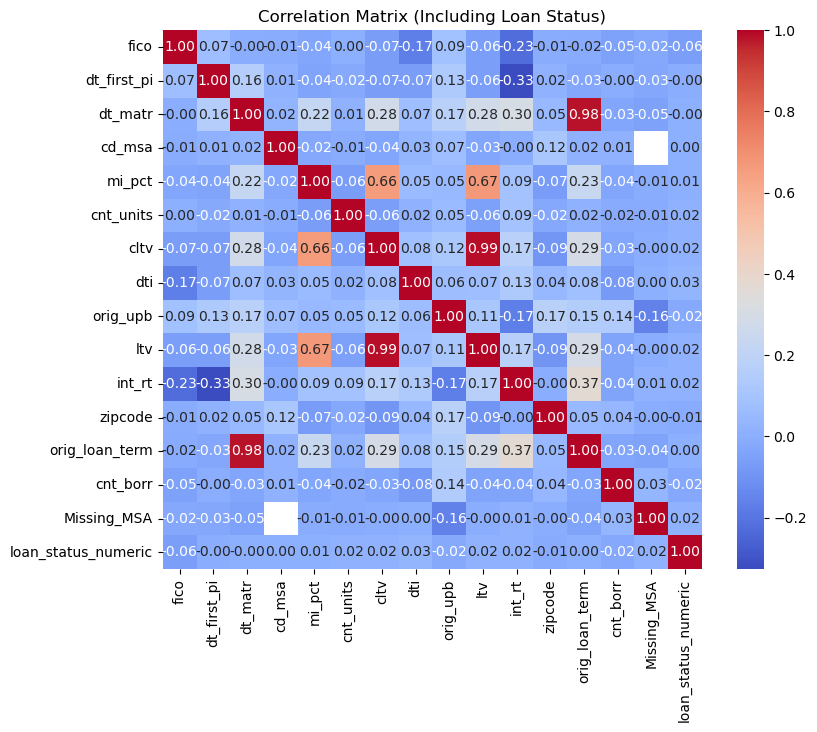

In [18]:
#Create a copy of the training features to avoid modifying the original DataFrame
temp = X_train.copy()
# Map loan status to numeric values
temp['loan_status_numeric'] = y_train
# Compute correlation matrix
corr = temp.select_dtypes(include='number').corr()
# Plot
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix (Including Loan Status)")
plt.show()

**Interpretation:**
- Most features show very weak linear correlation with loan_status_numeric. This is due to the extreme class imbalance (only 746 defaults vs 126,000 prepaid) that significantly reduces the variance in the target variable, which can suppress correlation values, even for meaningful predictors.
- We see an extreme correlation between **ltv** and **cltv** variables. Basically both these variables represent loan-to-value ratios with **ltv** applying only to primary mortgage loans and **cltv**  to all the loans secured by the property. This may suggest that we better use only one of these two metrics to avoid multicollinearity and to make models more interpretable.
- **dt_matr** (Maturity Date) is highly correlated with **orig_loan_term** because the maturity date is simply derived by adding the loan term to the start date, making it redundant for modeling. To avoid multicollinearity, we might choose to exclude dt_matr from the model and use orig_loan_term instead, as it captures the same information.
- **mi_pct** is also heavily correlated with **ltv** and **cltv** (66-67%) as they all reflect the risk associated with a loan: as the loan amount increases, the lender requires more insurance, resulting in a higher mortgage insurance percentage.
- **int_rt** (interest rate) and **dt_first_pi** (the first payment date) are negatively correlated. This suggests that as interest rates decrease, the first payment date tends to be later hinting at some historical pattern with decreasing interest rates over time in this time period.

**Potential implications for feature engineering**: 
- CLTV should be used in the model, but ltv (and potentially mi_pct) should be dropped as it is highly correlated with cltv and may not add additional value.

- dt_first_pi (first payment date) should be used as a feature, and dt_matr (maturity date) should be dropped as it doesn’t add much information for the predictive modeling process.

#### 2. Histograms of numerical features

The objective of plotting histograms for numeric features is to analyze their distributions, helping to identify skewness, outliers, and potential normality. This visualization aids in assessing whether feature scaling, such as normalization or standardization, is needed. It also allows for a comparative analysis of feature ranges, ensuring consistency before model training, and guides decisions on data preprocessing and feature engineering, ultimately improving model performance.

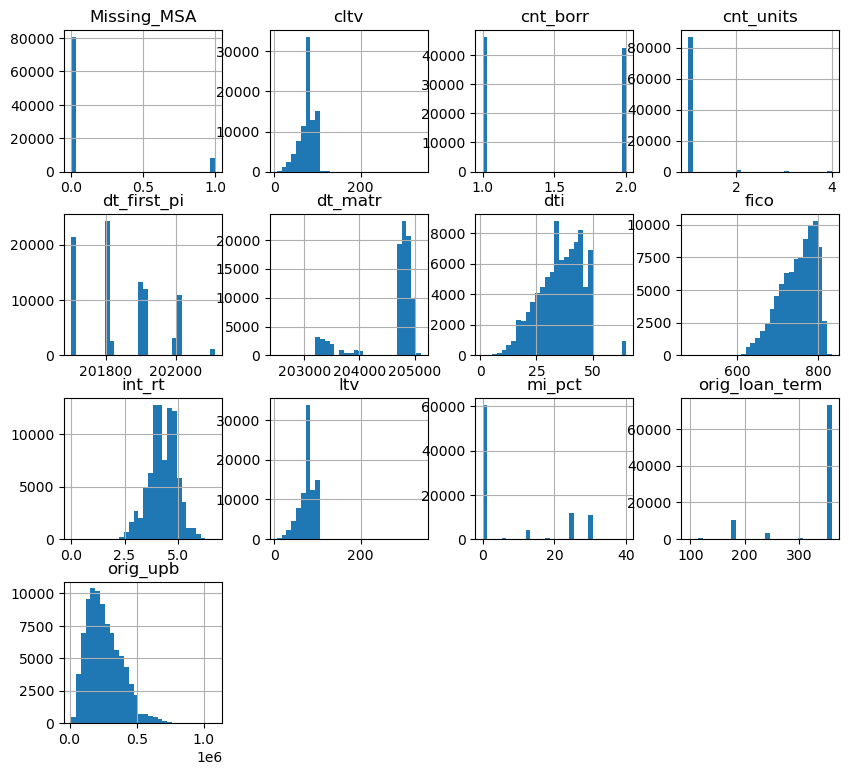

In [19]:
# Select only numeric columns, excluding 'cd_msa' and 'zipcode'
num_cols = X_train.select_dtypes(include='number').columns.difference(['cd_msa', 'zipcode'])
# Plot histograms for the numeric columns
X_train[num_cols].hist(figsize=(10, 9), bins=30)
plt.show()

**Interpretation**:

- **Missing_MSA**: The Missing_MSA feature shows a highly imbalanced distribution, with most entries marked as located in metropolitan statistical areas. We may state that the dataset is largely urban.

- **cltv** and **ltv** distributions have a skew towards 100 and a pronounced peak somewhere around 75.

- **cnt_bor** distrubution is balanced between 1 borrower and multiple borrowers.

- Payment dates suggest that the up to 2/3 of loans in our dataset are prior to 2019, with only few from 2021. Most loans have matriculation dates between 2045 and 2050 and most of them are scheduled for 360 months.

- **dti** is mostly concentrated in the lower ranges, with a few higher values, indicating that most borrowers have a relatively low debt-to-income ratio, but a significant number have higher ratios, particularly around 30-45. There is a visible drop at 45 potentially suggesting the existence of some existing policy rule.

- **fico** distribution is skewed with most scores clustered between 600-800, suggesting that the dataset primarily contains borrowers with average to good credit scores. Similarly, likely some internal policy rule for not accepting loans to those with fico below 600.

- unpaid balance **orig_upb** is distributed with a pronounced right skew

- **mi_pct** has a high concentration at 0%, indicating that many loans do not require mortgage insurance, and a smaller number have higher values.

**Potential implications for feature engineering**: 
- Log Transformations: Variables such as cltv, dti, orig_upb exhibit right skewness in their distributions. Applying a log transformation to these variables will help reduce the impact of extreme values and bring their distributions closer to normality. This transformation is particularly useful for improving model performance by making the relationships between features more linear and reducing the influence of outliers.

- Scaling: For variables like fico (credit score), orig_loan_term (loan term) and dt_first_pi, applying standardization or min-max scaling ensures that these features contribute equally to the model. This is important for algorithms sensitive to feature scaling (! like logistic regression), as it normalizes the data and ensures that features with larger numeric ranges do not dominate the learning process.

- Incorporating dates into the model could present challenges, as working with time series data requires significant effort in handling seasonality, trends, and temporal dependencies, which could complicate model development.


#### 3. How Default rate varies betweeen states.

In this section, we focus on exploring the geographic patterns in default behavior by analyzing the default rate across U.S. states. The dataset contains several geographic variables (state, zipcode, and msa) but visualizing zipcodes and msas meaningfully is challenging. As a result, we turn to the more interpretable and aggregated state-level data to examine whether default rates show regional variation. By calculating the percentage of defaulted loans within each state, we can assess whether location plays a significant role in loan outcomes. If we observe substantial variation across states, it may suggest that geographic features hold predictive power and should be considered in our modeling. Conversely, if default rates are relatively uniform across states, it could imply that such geographic variables contribute little explanatory value.

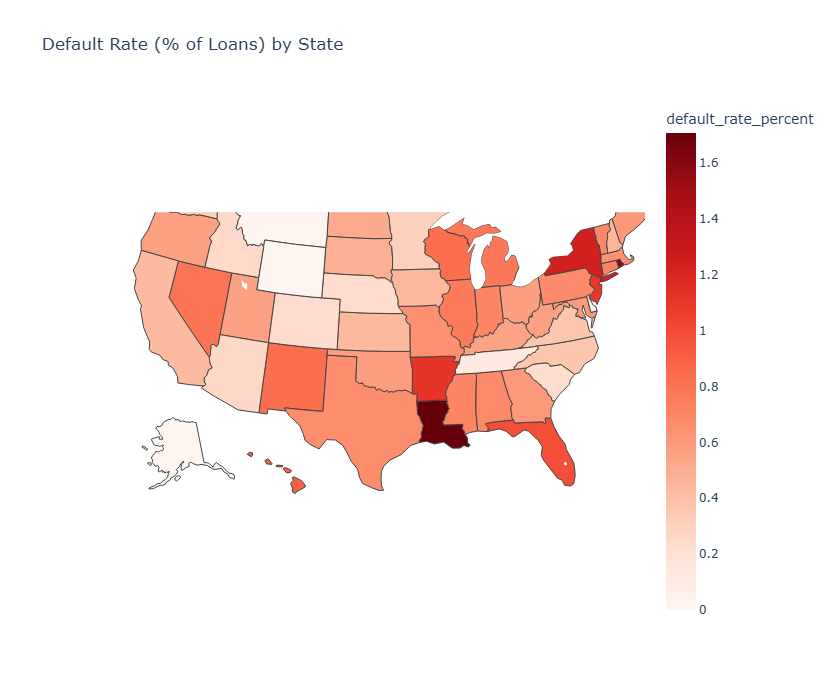

29     42    16     34     14     2      43     37  \
st                       LA     RI    NY     AR     NJ     FL     HI     NM   
total_loans             761    253  2016    539   2098   5600    224    361   
defaults               13.0    4.0  25.0    6.0   23.0   55.0    2.0    3.0   
default_rate_percent  1.708  1.581  1.24  1.113  1.096  0.982  0.893  0.831   

                        20   40   39   49   50   51   52   53  
st                      TN   DE   MT   AK   WY   GU   PR   VI  
total_loans           1824  296  311  130  127    7    5    3  
defaults               2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
default_rate_percent  0.11  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [20]:
 # Make a copy to ensure original X_test is not altered
X_train_temp = X_train.copy() 
# Add 'loan_status' temporarily to the copied data
X_train_temp['loan_status'] = y_train  
merged_state = calculate_default_rate(X_train_temp, 'st')
# Visualize the default rate using Plotly choropleth map
fig = px.choropleth(merged_state,locations='st',locationmode='USA-states',  color='default_rate_percent',
                    scope='usa',color_continuous_scale='reds',title='Default Rate (% of Loans) by State',
                    width=50,height=70)
fig.show()
# Show number of loans, defaults, and default rate for states in a table
merged_state = merged_state.sort_values(by='default_rate_percent', ascending=False)
# Display the table 
merged_first_last = pd.concat([merged_state.head(8), merged_state.tail(8)])
merged_first_last.T

**Interpretation**: The default rate map shows significant variation in default rates across states, with some states having much higher rates than others. This suggests that state and other geographical variables are likely to be important predictors in our models, as they can capture regional differences in loan default risk and improve model performance.

#### 4. How Default rate varies betweeen the sellers of mortgages.

This table is created to analyze how default rates vary across different loan sellers. By comparing the default rates, we can realise whether seller name is going to be an important predictor for our future model.

In [56]:
# Apply the calculate_default_rate function to the 'seller_name' column in X_train_temp
merged2 = calculate_default_rate(X_train_temp, 'seller_name')
# Concatenate the first 3 rows and the last 3 rows for display
merged2_first_last = pd.concat([merged2.head(5), merged2.tail(5)])
# Display the result
merged2_first_last

seller_name  total_loans  defaults  \
34                            NATIONSTAR MORTGAGE LLC          283       7.0   
44                                   FIFTH THIRD BANK           75       1.0   
39                       FIFTH THIRD MORTGAGE COMPANY          158       2.0   
12  UNITED SHORE FINANCIAL SERVICES, LLC, DBA UNIT...         1369      17.0   
43                     UNITED WHOLESALE MORTGAGE, LLC           83       1.0   
41                                   NORTHPOINTE BANK           95       0.0   
45                                 CITIMORTGAGE, INC.           53       0.0   
46                     AMERISAVE MORTGAGE CORPORATION           25       0.0   
47                         CROSSCOUNTRY MORTGAGE, LLC           20       0.0   
48                        PENNYMAC LOAN SERVICES, LLC           15       0.0   

    default_rate_percent  
34                 2.473  
44                 1.333  
39                 1.266  
12                 1.242  
43                 1.205  
41                 0.000  
45                 0.000  
46                 0.000  
47                 0.000  
48                 0.000

**Interpretation**: The table illustrates that the default rate varies significantly across different sellers, independent of the total number of loans sold by each seller. For example, Nationstar Mortgage LLC has a default rate of 2.47% with 283 loans, while Primelending has a default rate of 0%, despite selling 304 loans. This indicates that the seller variable plays a crucial role in predicting loan defaults, making it a likely major predictor in our models, regardless of the volume of loans each seller has originated. The wide variation in default rates suggests that different sellers may have different levels of risk, which could enhance the model's predictive accuracy.

#### 5. How Default rate varies betweeen the servicers of mortgages.

For the similar reason we provide a similar table for the servicers of mortgages. 

In [58]:
# Apply the calculate_default_rate function to the 'servicer_name' column in X_train_temp
merged3 = calculate_default_rate(X_train_temp, 'servicer_name')
# Concatenate the first 3 rows and the last 3 rows for display
merged3_first_last = pd.concat([merged3.head(3), merged3.tail(8)])
# Display the final result
merged3_first_last

servicer_name  total_loans  defaults  \
18   SPECIALIZED LOAN SERVICING LLC         1322      62.0   
37               FLAGSTAR BANK, FSB           72       1.0   
0                   Other servicers        24212     251.0   
36         ONSLOW BAY FINANCIAL LLC           79       0.0   
38            GUARANTEED RATE, INC.           60       0.0   
39               CITIMORTGAGE, INC.           53       0.0   
40  FINANCE OF AMERICA MORTGAGE LLC           35       0.0   
41     MARLIN MORTGAGE CAPITAL, LLC           31       0.0   
42       CROSSCOUNTRY MORTGAGE, LLC           20       0.0   
43      PENNYMAC LOAN SERVICES, LLC           15       0.0   
44   AMERISAVE MORTGAGE CORPORATION           13       0.0   

    default_rate_percent  
18                 4.690  
37                 1.389  
0                  1.037  
36                 0.000  
38                 0.000  
39                 0.000  
40                 0.000  
41                 0.000  
42                 0.000  
43                 0.000  
44                 0.000

The table shows the default rates for various loan servicers, with significant variation across them. For example, Specialized Loan Servicing LLC has the highest default rate of 4.69% despite handling 1,322 loans, while ROCKET MORTGAGE, LLC	. has a default rate 4 times lower (0.928%) handling 1940 loans.

This disparity in default rates suggests that loan servicers play a crucial role in determining default risk, and some servicers may be associated with higher-risk loans than others. Servicers with higher default rates, like Specialized Loan Servicing LLC, might have more complex loan portfolios or might be associated with specific borrower types. Conversely, servicers with 0% default rates may represent lower-risk loans or better borrower management practices.

#### 6. How Default rate is associated with various numeric variables.

In this section, we analyze the distribution of key numerical variables—FICO score, Mortgage Insurance Percentage (MI%), Interest Rate (int_rt), and Loan-to-Value (CLTV)—across different loan statuses (prepaid and default) using violin plots.

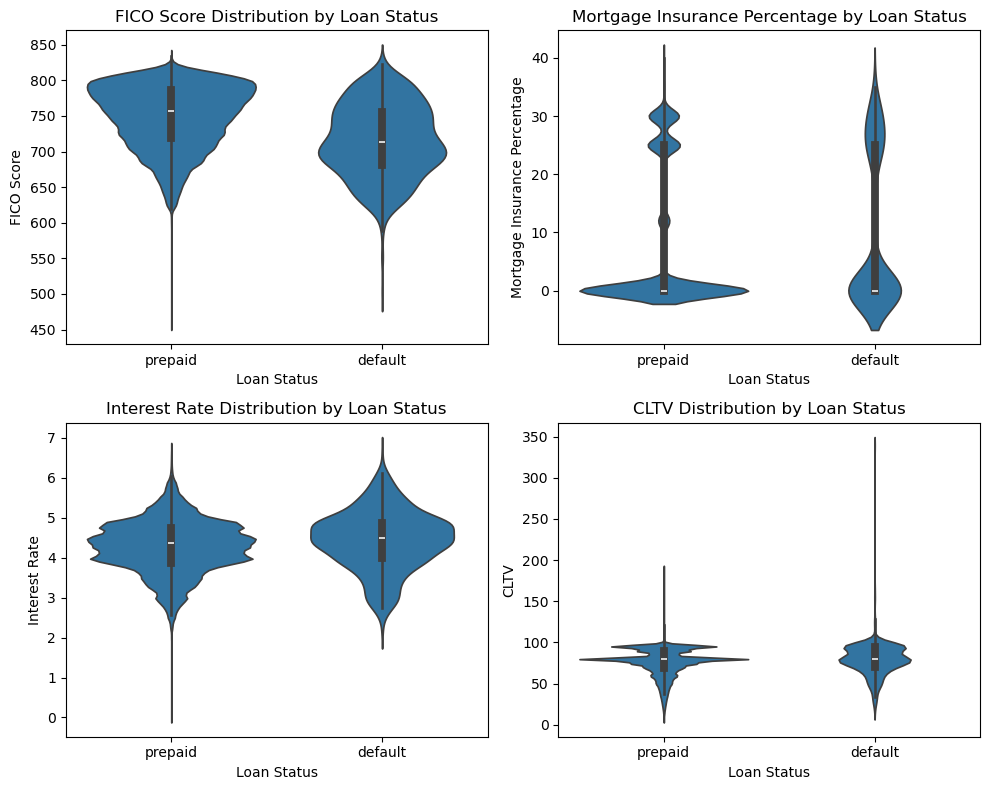

In [23]:
# Create subplots with 2 rows and 2 columns (for FICO, MI%, int_rt, cltv, and Missing_MSA)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Violin plot for FICO Score by Loan Status
sns.violinplot(x='loan_status', y='fico', data=df, inner='box', ax=axes[0, 0])
axes[0, 0].set_title('FICO Score Distribution by Loan Status')
axes[0, 0].set_xlabel('Loan Status')
axes[0, 0].set_ylabel('FICO Score')
# Violin plot for Mortgage Insurance Percentage by Loan Status
sns.violinplot(x='loan_status', y='mi_pct', data=df, inner='box', ax=axes[0, 1])
axes[0, 1].set_title('Mortgage Insurance Percentage by Loan Status')
axes[0, 1].set_xlabel('Loan Status')
axes[0, 1].set_ylabel('Mortgage Insurance Percentage')
# Violin plot for Interest Rate by Loan Status
sns.violinplot(x='loan_status', y='int_rt', data=df, inner='box', ax=axes[1, 0])
axes[1, 0].set_title('Interest Rate Distribution by Loan Status')
axes[1, 0].set_xlabel('Loan Status')
axes[1, 0].set_ylabel('Interest Rate')
# Violin plot for CLTV by Loan Status
sns.violinplot(x='loan_status', y='cltv', data=df, inner='box', ax=axes[1, 1])
axes[1, 1].set_title('CLTV Distribution by Loan Status')
axes[1, 1].set_xlabel('Loan Status')
axes[1, 1].set_ylabel('CLTV')
# Adjust layout to make space for titles and labels
plt.tight_layout()
plt.show()

**Interpretation**: 
- FICO Score: The FICO score is notably differently distributed between prepaid and default loans. Loans that default tend to have a broader range of FICO scores, with a higher concentration of defaults among lower credit scores. In contrast, prepaid loans generally exhibit a narrower range, with higher FICO scores dominating the distribution. Fico is likely to be a significant predictor of defaults.
- CLTV:  While both distributions are centered around similar CLTV values (roughly 70–90), the defaulted loans have a wider spread and a longer tail extending toward very high CLTV values (above 200 and up to 350), suggesting that defaults are more likely among loans with exceptionally high leverage.
- Interest Rates: Both distributions centered around tsimilar values, nut most of the very low-interest loans are among prepaid.
- mi_pct: no visible trend observed

#### 7. Default Rate Analysis by Occupancy Status, Number of Units, Loan Purpose, and Property Type

In this section, we analyze the default rate for various features, including Occupancy Status, Number of Units, Loan Purpose, and Property Type.

In [24]:
# Merge tables for `occpy_sts` (Occupancy Status)
merged_occpy_sts = calculate_default_rate(X_train_temp, 'occpy_sts')
# Merge tables for `cnt_units` (Number of Units)
merged_cnt_units = calculate_default_rate(X_train_temp, 'cnt_units')
# Merge tables for `loan_purpose` (Loan Purpose)
merged_loan_purpose = calculate_default_rate(X_train_temp, 'loan_purpose')
# Merge tables for `prop_type` (Property Type)
merged_prop_type = calculate_default_rate(X_train_temp, 'prop_type')
# Display merged tables for each feature (optional)
print("Occupancy Status Default Rate:")
print(merged_occpy_sts)
print("\nNumber of Units Default Rate:")
print(merged_cnt_units)
print("\nLoan Purpose Default Rate:")
print(merged_loan_purpose)
print("\nProperty Type Default Rate:")
print(merged_prop_type)

Occupancy Status Default Rate:
  occpy_sts  total_loans  defaults  default_rate_percent
1         I         6417        66                 1.029
0         P        78847       439                 0.557
2         S         3429        17                 0.496

Number of Units Default Rate:
   cnt_units  total_loans  defaults  default_rate_percent
2        3.0          251         6                 2.390
1        2.0         1189        20                 1.682
3        4.0          227         3                 1.322
0        1.0        87026       493                 0.566

Loan Purpose Default Rate:
  loan_purpose  total_loans  defaults  default_rate_percent
2            C        18502       124                 0.670
1            N        19552       112                 0.573
0            P        50639       286                 0.565

Property Type Default Rate:
  prop_type  total_loans  defaults  default_rate_percent
3        MH          265         9                 3.396
4        

**Interpretation**: 
- Occupancy Status: Investment properties (I) have a higher default rate (1.029%) compared to primary residences (P) (0.557%), suggesting more risk for non-owner-occupied properties.

- Number of Units: Loans for 3-unit properties have the highest default rate (2.390%), with single-unit properties showing the lower rate (0.566%).

- Loan Purpose: Cash-out Refinance (C) loans have the highest default rate at 0.67%, followed by No Cash-out Refinance (N) at 0.573%, and Purchase mortgages (P) with the lowest default rate at 0.565%.

- Property Type: Mobile homes (MH) and condominiums (CP) show the highest default rate (3.295% and 1.802%), while single-family homes (SF) and planned unit development (PU) have lower rates.

##### ❗️❗️❗️ Target Encoding ❗️❗️❗️

In this section, we apply manual target encoding to the categorical variables seller_name, servicer_name, zipcode, and st. Due to technical issues, I was unable to implement this step using TargetEncoder from external libraries or by embedding it directly within a preprocessing pipeline. As a workaround, I computed the mean target value (default rate) for each category outside the pipeline, and created new encoded features (e.g., seller_name_te).

Target encoding is used here to reduce the dimensionality of high-cardinality categorical variables and avoid one-hot encoding, which would have introduced a large number of sparse features for columns like state, servicer_name, and seller_name. This helps keep the feature space compact and improves model efficiency.

##### ❗️Attempting to Avoid Data Leakage ❗️

To ensure no data leakage, the encoding is based only on the training data (X_train). The target means for each category are computed using X_train and y_train, and those same mappings are then applied to X_test. This prevents any information from the test set from influencing the encoding process, which is crucial for maintaining the integrity and generalizability of the model.

In [25]:
# Attach target temporarily
X_train_enc = X_train.copy()
X_train_enc['target'] = y_train
# Manually apply target encoding to high-cardinality categorical features
# This replaces categories with their default rate (mean of target), reducing dimensionality
# and avoiding sparse one-hot encoded columns
for col in ['seller_name', 'servicer_name', 'st', "zipcode"]:
    means = X_train_enc.groupby(col)['target'].mean() # default rate per category
    global_mean = y_train.mean()
    # Map means to training data
    X_train[col + '_te'] = X_train[col].map(means).fillna(global_mean)
    # Map same means to test data
    X_test[col + '_te'] = X_test[col].map(means).fillna(global_mean)

# Model Fitting and Tuning

## Baseline - Logistic Regression

Logistic regression is a widely used statistical model for binary classification tasks. Instead of directly predicting a class label (e.g., default or prepaid), it estimates the probability that a given observation belongs to the positive class - in this case, a loan default. These probabilities range from 0 to 1 and are derived from a weighted combination of the input variables, passed through a logistic function. By default, observations with a predicted probability greater than or equal to 0.5 are classified as defaults, while those below this threshold are classified as prepaid.

In this section, we construct a baseline logistic regression model to predict whether a borrower will default on their mortgage. This model serves as a benchmark to evaluate the performance of more advanced models developed later in the project. It emphasizes interpretability, simplicity, and a strong foundation for comparison.

To prepare the data, we implemented several preprocessing strategies:

- Binary indicators such as flag_sc and rr_ind were manually converted using a custom function (map_Y_to_1) to map "Y" to 1 and missing or other values to 0.

- For skewed numerical features (fico, cltv, dti, orig_upb, mi_pct), we applied log transformation followed by standard scaling to reduce the influence of outliers and normalize distributions.

- Standard scaling was also applied to numeric predictors like cnt_units, int_rt, cnt_borr, and the target-encoded features described below.

Due to technical limitations, we were unable to apply target encoding inside the pipeline using built-in tools like TargetEncoder or FunctionTransformer. Instead, we computed manual target encodings outside the pipeline, where each category in high-cardinality variables (seller_name, servicer_name, zipcode and st) was replaced with its default rate - calculated as the mean of the binary target in the training set. This helps preserve predictive signal while avoiding one-hot encoding, which would otherwise lead to a large, sparse feature space.

- We used class_weight='balanced' in the logistic regression model to address class imbalance, ensuring that the model gives appropriate importance to the minority class (defaults), which would otherwise be underrepresented in the loss function and lead to biased predictions toward the majority class.

This baseline will serve as a reference point: if future tree-based models do not significantly outperform this model in both accuracy and interpretability, their added complexity may not be justified.

In [26]:
# function to convert 'Y' flags to binary (1 if 'Y', else 0)
def map_Y_to_1(X):
    return (X == 'Y').astype(int)
# Pipeline to apply log transformation followed by standard scaling to skewed numeric features    
log_numeric_pipe = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scale', StandardScaler())])

In [27]:
log_preprocessor = ColumnTransformer([
    # Convert binary flags 'flag_sc' and "rr_ind" ("Y"/blank) to 1/0
    ('flag_sc', FunctionTransformer(map_Y_to_1, feature_names_out='one-to-one'), ['flag_sc']),
    ('rr_ind', FunctionTransformer(map_Y_to_1, feature_names_out='one-to-one'), ["rr_ind"]),
    # One-hot encode 'flag_fthb', dropping 'N' as reference category
    ("flag_fthb", OneHotEncoder(drop=["N"]), ["flag_fthb"]),
    # One-hot encode other categorical features, dropping the first category in each for reference
    ('categoricals', OneHotEncoder(drop='first'), [
        'occpy_sts', "channel", "prop_type", "loan_purpose", 
        'Missing_MSA', "program_ind", "mi_cancel_ind", "property_val"]),
    # Apply log transformation + scaling to skewed numeric features
    ("log_numeric", log_numeric_pipe, ['fico', 'cltv', 'dti', 'orig_upb', 'mi_pct']), 
    # Standard scale other numeric features (including target-encoded variables)
    ("numeric", StandardScaler(), [
        'cnt_units', 'int_rt', 'cnt_borr', 
        'seller_name_te', 'servicer_name_te', "st_te", "zipcode_te"])
], remainder="drop")
log_pipe = make_pipeline(
    log_preprocessor, 
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')  )

In [28]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('flag_sc',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function map_Y_to_1 at 0x7fa57e5ab240>),
                                                  ['flag_sc']),
                                                 ('rr_ind',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function map_Y_to_1 at 0x7fa57e5ab240>),
                                                  ['rr_ind']),
                                                 ('flag_fthb',
                                                  OneHotEncoder(drop=['N']),
                                                  ['flag_f...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fico', 'cltv', 'dti',
                                                   'orig_upb', 'mi_pct']),
                                                 ('numeric', StandardScaler(),
                                                  ['cnt_units', 'int_rt',
                                                   'cnt_borr', 'seller_name_te',
                                                   'servicer_name_te', 'st_te',
                                                   'zipcode_te'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

##### Reference Category
This step is performed to identify the reference category for each one-hot encoded categorical variable, which is the category that gets dropped during encoding when using drop='first'. In logistic regression, the model estimates coefficients relative to this baseline group, so understanding which category was omitted is essential for correctly interpreting the direction and meaning of the coefficients. By extracting and displaying the first (alphabetically sorted) unique value of each categorical feature, we clarify what each remaining dummy variable is being compared against in the model.

In [29]:
# List of one-hot encoded categorical columns
categorical_cols = ['occpy_sts', "channel", "prop_type", "loan_purpose", 
    'Missing_MSA', "program_ind", "mi_cancel_ind", "property_val"]
# Get the first (reference) category for each feature
reference_categories = {}
for col in categorical_cols:
    unique_vals = sorted(X_train[col].dropna().unique())  # drop NAs and sort
    if unique_vals:  # in case the column is empty
        reference_categories[col] = unique_vals[0]  # first = reference when drop='first'
# Show as DataFrame
ref_df = pd.DataFrame.from_dict(reference_categories, orient='index', columns=['Reference Category'])
ref_df.index.name = 'Feature'
ref_df.reset_index(inplace=True)
# Add descriptions for each reference category
reference_explanations = {
    'occpy_sts': "Investment Property",
    'channel': "Broker",
    'prop_type': "Condominium",
    'loan_purpose': "Cash-out Refinance",
    'Missing_MSA': "MSA code is not missing (urban/metropolitan area)",
    'program_ind': "Not Applicable (is not in any program)",
    'mi_cancel_ind': "Not Applicable (likely no Mortgage Insurance)",
    'property_val': "Property value obtained via ACE Loans"}
# Map explanations to the DataFrame
ref_df['Explanation'] = ref_df['Feature'].map(reference_explanations)
# Display the final table
display(ref_df)

Feature Reference Category  \
0      occpy_sts                  I   
1        channel                  B   
2      prop_type                 CO   
3   loan_purpose                  C   
4    Missing_MSA                  0   
5    program_ind                  9   
6  mi_cancel_ind                  7   
7   property_val          ACE Loans   

                                         Explanation  
0                                Investment Property  
1                                             Broker  
2                                        Condominium  
3                                 Cash-out Refinance  
4  MSA code is not missing (urban/metropolitan area)  
5             Not Applicable (is not in any program)  
6      Not Applicable (likely no Mortgage Insurance)  
7              Property value obtained via ACE Loans

##### Coefficients of Baseline Model

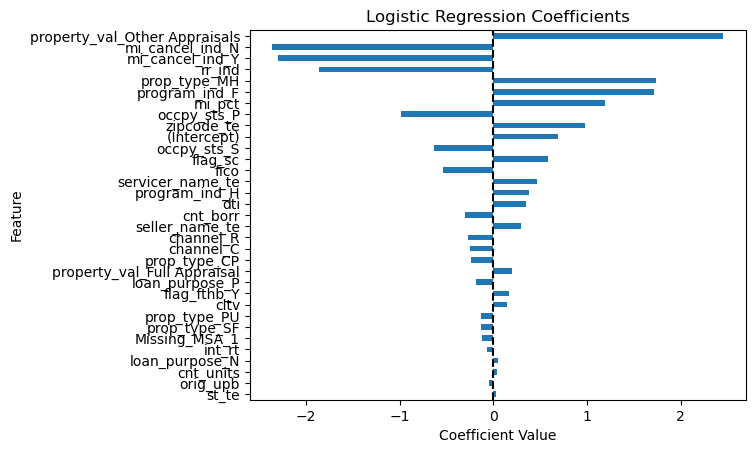

In [30]:
# Extract feature names and coefficients
preprocessor = log_pipe.named_steps['columntransformer']
model = log_pipe.named_steps['logisticregression']
# Get transformed feature names
feature_names = get_feature_names(preprocessor)
# Create DataFrame for coefficients
coefs = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.coef_.flatten()})
# Add the intercept as a separate row
intercept_row = pd.DataFrame({
    "Feature": ["(Intercept)"],
    "Coefficient": model.intercept_})
# Append the intercept row to the coefficient DataFrame
coefs = pd.concat([coefs, intercept_row], ignore_index=True)
# Sort by absolute value
coefs_sorted = coefs.reindex(coefs.Coefficient.abs().sort_values(ascending=False).index)
# Show the result
coefs_sorted.plot.barh(x='Feature', y='Coefficient', legend=False)  
plt.title("Logistic Regression Coefficients")
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()

#### Interpretation of Findings:

- Categorical features are interpreted relative to a reference category (due to one-hot encoding with drop='first')

- Numerical features (e.g., fico, dti) have been standardized or log-transformed, so their coefficients reflect impact per unit of transformation.


🔺 ***Features Associated with Higher Risk of Default (Positive Coefficients)***:

**property_val_Other Appraisals (2.53)**
→ Compared to loans with ACE Loans property valuations (reference), those using Other Appraisal methods (e.g., desktop, drive-by, AVM) have a significantly higher risk of default.

**mi_cancel_ind_N (2.63)** and **mi_cancel_ind_Y (2.50)**
→ Compared to loans with ‘7’ (Not Applicable) (reference), both ‘N’ (MI not canceled) and ‘Y’ (MI canceled) indicate a substantially higher risk of default, potentially reflecting loans with higher original risk or borrower instability.

**mi_pct (1.30)**
→ Higher Mortgage Insurance Percentages are strongly associated with increased default risk.

**zipcode_te (0.98)**
→ Zip codes with historically higher default rates contribute a strong positive effect, making location a critical risk factor. This is surprisingly high for a geographic feature, and it suggests zip code is more informative than state.
→ As a result, st_te (state) has a very low coefficient (0.03), implying that zip codes absorb much of the geographic risk signal in the model.

**prop_type_MH (1.68)**
→ Manufactured Homes are riskier compared to the reference group: Condominiums (CO).

**program_ind_F (1.57)**
→ Loans in Program F have greater odds of default compared to loans with Program 9 (Not Available) (reference).

**dti (0.38)**
→ Higher Debt-to-Income Ratio is associated with increased risk of default (numerical, standardized).

🟢 ***Features Associated with Lower Risk of Default (Negative Coefficients)***:

**rr_ind (-1.64)**
→ Loans marked with Refinance Indicator = Y show much lower risk of default compared to those left blank (reference).

**occpy_sts_P (-0.91) and occpy_sts_S (-0.65)**
→ Compared to Investment Properties (I) (reference), Primary (P) and Secondary (S) residences are much less likely to default.

**flag_sc (-0.59)**
→ Loans with Streamlined Credit flag = Y are less likely to default compared to blank (reference).

**fico (-0.39)**
→ A higher credit score reduces the odds of default, as expected (numerical feature, standardized).

**prop_type_CP, prop_type_PU, prop_type_SF**
→ All show lower or mildly negative effects relative to the Condominium (CO) reference category.

🔘 ***Features with neutral and smaller effects***

**seller_name_te, servicer_name_te, cltv, orig_upb**
→ Surprisingly, these features show relatively small coefficients, suggesting that institution-specific effects (i.e., who originated or serviced the loan) may be largely absorbed by other, more important features — potentially zipcode_te, which captures localized economic risk that often correlates with institutional lending patterns or borrower demographics.



#### Baseline Model Evaluation

In this section, we evaluate the performance of our baseline logistic regression model, which serves as the benchmark for all future predictive models. The model was trained using a carefully preprocessed dataset, incorporating standardized numerical features, one-hot encoded categorical variables, and target-encoded high-cardinality variables such as state, seller, and ZIP code. We assess the model’s effectiveness in predicting loan default by examining key classification metrics, including accuracy, precision, recall, F1 score, ROC AUC, and the precision-recall curve. 


**Confusion Matrix**

<Figure size 100x100 with 0 Axes>

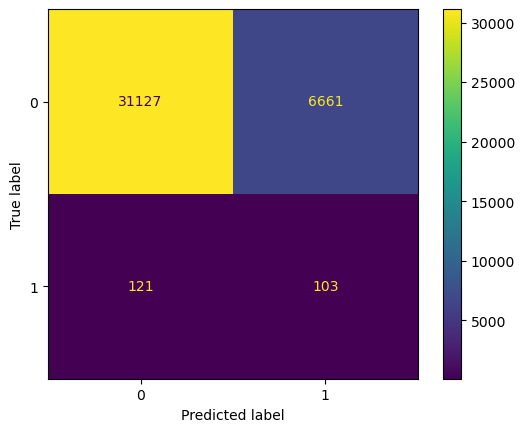

In [31]:
plt.figure(figsize=(1, 1)) 
ConfusionMatrixDisplay.from_estimator(log_pipe, X_test, y_test)
plt.show()

**Interpretation**: The confusion matrix shows that the baseline logistic regression model achieves reasonably good performance, correctly classifying a large number of prepaid loans and about half of all defaults. While overall accuracy is high, this is largely driven by the class imbalance in the data, where prepaid loans dominate. The model identifies 102 out of 224 defaults correctly, but still misses 122, and misclassifies a number of prepaid loans as defaults.


**Evaluation Metrics**

In [32]:
y_pred = log_pipe.predict(X_test)
y_proba = log_pipe.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):1f}")

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     37788
           1       0.02      0.46      0.03       224

    accuracy                           0.82     38012
   macro avg       0.51      0.64      0.47     38012
weighted avg       0.99      0.82      0.90     38012

ROC AUC: 0.734980


**Interpretation**: The baseline logistic regression model achieves a relatively high accuracy of 82%, which is largely driven by the dominance of non-default (prepaid) cases in the dataset. However, the metrics specific to the default class (positive class) reveal important weaknesses:

- Precision (1.5%) indicates that only a tiny fraction of the loans predicted as defaults were actually defaults.

- Recall (45.5%) is moderate, showing the model managed to identify almost half of the true defaults.

- F1 Score (2.9%), which balances precision and recall, is very low—highlighting poor overall predictive power for the rare class.

As we move forward, a key challenge will be deciding which evaluation metric to prioritize. For example, future models might achieve better precision (fewer false positives) but at the cost of recall (missing more actual defaults), or vice versa. The metric we choose to optimize should reflect the business or policy implications of misclassifying defaults - whether it is more costly to miss them or to incorrectly flag them (likely the former one).

**ROC curve, AUC and Precision-Recall**

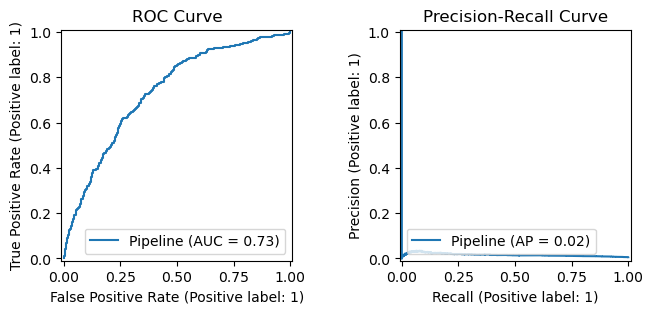

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
# ROC curve plot
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test, ax=axes[0])
axes[0].set_title('ROC Curve')
# Precision-Recall curve plot
PrecisionRecallDisplay.from_estimator(log_pipe, X_test, y_test, ax=axes[1])
axes[1].set_title('Precision-Recall Curve')
plt.show()

**Interpretation**: The ROC curve above provides a comprehensive view of the model's ability to distinguish between the default and prepaid classes across various classification thresholds. The Area Under the Curve (AUC) is approximately 0.74, indicating that the model has moderate discriminative power.

This means that there is a 74% chance that the model will assign a higher score to a randomly chosen defaulted loan than to a prepaid one. While not perfect, an AUC above 0.7 generally suggests that the model is capturing meaningful signals - although there is still considerable room for improvement, especially given the class imbalance and low precision observed earlier.

The Precision-Recall (PR) curve evaluates the baseline logistic regression model’s ability to detect the minority class - loan defaults. The curve shows that the model achieves very low precision across all recall levels, with the average precision (AP) score being just 0.02. This means that, on average, only 2% of the loans predicted as defaults are actually defaults - a very high false positive rate. The steep drop in precision after recall slightly increases also confirms that the model struggles to balance correctly identifying defaults (recall) while minimizing incorrect default predictions (precision).


## Advanced Model - Random Forest

Our final model is a Random Forest classifier, a robust ensemble method that constructs multiple decision trees on bootstrapped subsets of the data and combines their outputs to make final predictions. This method captures nonlinear relationships and interactions between variables, and naturally reduces overfitting due to its random sampling of both observations and features. Given the complexity of our data and the presence of imbalanced classes, Random Forests provide a flexible, high-performing solution.

### 1. New Preprocessor

❗️ **We Do Not Need Scaling or Log Transformation in Preprocessing** ❗️

Unlike models such as logistic regression, tree-based algorithms (like Random Forests) do not require feature scaling or log transformation. These models split features based on thresholds rather than relying on distance or magnitude, making them invariant to the scale of input variables. This simplifies our preprocessing pipeline: numerical values are passed through without transformation, but categorical variables are still handled using one-hot encoding.

In [34]:
rf_preprocessor = ColumnTransformer([
    # Binary indicators
    ('flag_sc', FunctionTransformer(map_Y_to_1, feature_names_out='one-to-one'), ['flag_sc']),
    ('rr_ind', FunctionTransformer(map_Y_to_1, feature_names_out='one-to-one'), ['rr_ind']),
    # One-hot encode categoricals
    ('flag_fthb', OneHotEncoder(drop=["N"]), ['flag_fthb']),
    ('categoricals', OneHotEncoder(drop='first'), [
        'occpy_sts', 'channel', 'prop_type', 'loan_purpose',
        'Missing_MSA', 'program_ind', 'mi_cancel_ind', 'property_val']),
    # Pass numeric columns with no scaling, no log
    ('numeric', 'passthrough', [
        'fico', 'cltv', 'dti', 'orig_upb', 'mi_pct',
        'cnt_units', 'int_rt', 'cnt_borr',
        'seller_name_te', 'servicer_name_te', 'st_te', 'zipcode_te'])
], remainder='drop')

### 2. Addressing Class Imbalance with Weights and SMOTE

Once again, one of the most significant challenges in our dataset is class imbalance, where prepaid loans dominate over defaults. To prevent the model from always predicting the majority class, we use two strategies (as using only class weights proved to not be sufficient):

- Class Weights: We apply class_weight='balanced' to ensure that misclassifying a default is penalized more than misclassifying a prepaid loan. This forces the model to pay more attention to the minority class.

- SMOTE (Synthetic Minority Oversampling Technique): SMOTE is applied within our pipeline to synthetically generate new instances of the minority class by interpolating between existing samples. This creates a more balanced training set without simply duplicating observations, allowing the model to better learn default patterns.

Both strategies work together - one adjusts the learning algorithm, the other adjusts the data itself - to mitigate the bias introduced by imbalanced classes.

In [35]:
rf_pipe = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0, k_neighbors=3, random_state=42)),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))])


### 3. Adressing Overfitting 

We decided not to apply pruning using ccp_alpha in our Random Forest model. This is because Random Forests already manage overfitting effectively through the ensemble of multiple trees, averaging their predictions to reduce variance. Pruning individual trees could simplify the model, but it might also limit the diversity of the trees in the forest, reducing the overall power of the model. Additionally, since we are already tuning other hyperparameters like max_depth and n_estimators, pruning would likely provide minimal additional benefits compared to the improvements we could achieve through hyperparameter optimization. Therefore, we chose to focus on these other tuning strategies for better model performance.

#### Using OOB Score to choose optimal max features

To assess overfitting, we use the Out-of-Bag (OOB) score, a built-in cross-validation technique specific to Random Forests. Since each tree in a Random Forest is trained on a random bootstrap sample of the data, approximately one-third of the training samples are left out ("out-of-bag") for that tree. These left-out observations are then used to test the tree's performance, providing an unbiased estimate of model accuracy without the need for a separate validation set. By evaluating how the OOB score varies with different values of max_features, we can select a configuration that balances model complexity with generalizability, thus reducing the likelihood of overfitting while still capturing important patterns in the data.

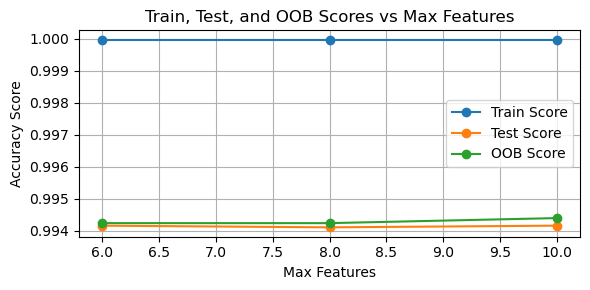

Best max_features = 10 with OOB Score = 0.9944


In [81]:
rf_pipe = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0, k_neighbors=3, random_state=42)), 
    ('model', RandomForestClassifier(
        random_state=42,class_weight='balanced',
        oob_score=True, max_features=14))])
rf_pipe.fit(X_train, y_train)
# Pre-transform training data using your preprocessor
X_train_rf = rf_preprocessor.fit_transform(X_train)
X_test_rf = rf_preprocessor.transform(X_test)
max_features_range = [6, 8, 10]
train_scores = []
test_scores = []
oob_scores = []
for m in max_features_range:
    rf = RandomForestClassifier(
        n_estimators=100, max_features=m,
        oob_score=True, random_state=42,n_jobs=-1)
    rf.fit(X_train_rf, y_train)
    # Calculate train and test scores
    train_scores.append(accuracy_score(y_train, rf.predict(X_train_rf)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test_rf)))
    # Get OOB score
    oob_scores.append(rf.oob_score_)
plt.figure(figsize=(6, 3))
plt.plot(max_features_range, train_scores, label='Train Score', marker='o')
plt.plot(max_features_range, test_scores, label='Test Score', marker='o')
plt.plot(max_features_range, oob_scores, label='OOB Score', marker='o')
plt.xlabel('Max Features'); plt.ylabel('Accuracy Score')
plt.title('Train, Test, and OOB Scores vs Max Features')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
# Best max_features and corresponding OOB score
best_m = max_features_range[np.argmax(oob_scores)]
print(f"Best max_features = {best_m} with OOB Score = {max(oob_scores):.4f}")

**Interpretation**:  This plot shows how the model's performance (train, test, and OOB scores) changes as we adjust the number of features used per split in the decision trees. As expected, the train score is consistently perfect (1.0), but the more important metrics here are the test and OOB scores, which show how well the model generalizes to unseen data.

What stands out is the OOB score, which remains consistently high (around 0.994) no matter how many features are used in each tree. This tells us that the model is doing a great job at generalizing, even as the complexity of the trees increases. Interestingly, there’s no significant change in the test or OOB performance as we increase the number of features, suggesting that adding more features to the trees doesn’t really boost the model’s ability to predict on unseen data.

In simple terms, the model is stable and not overfitting - whether we use a few or many features at each split, it still performs well on both the training and unseen data. 

### 4. Model Tuning

Model performance can be evaluated using many metrics: accuracy, precision, recall, F1 score, or AUC. However, optimizing for all of them simultaneously is not practical in our imbalanced classification problem, where some metrics can be misleading. For instance, high accuracy simply reflects the model’s ability to predict the majority class, while saying little about performance on the minority class (defaults).

Unlike the baseline logistic regression model, where we relied on default settings and did not tune for any specific metric, the Random Forest model provides us with the flexibility to explicitly optimize for one performance objective. This flexibility is crucial for aligning the model’s behavior with the goals of our application.

❗️❗️❗️**We focus on Recall**❗️❗️❗️

We suppose that for a bank or lending institution, failing to detect a default can have significant financial consequences. Therefore, we decide to prioritize recall - the ability of the model to correctly identify defaults - even at the cost of some false positives. Maximizing recall ensures that most high-risk loans are flagged. We believe that this aligns with real-world objectives where false negatives (missed defaults) are costlier than false positives (false alarms).

**How We Tune the Model for Recall**

To optimize recall, we use **Grid Search**. We use cross-validated grid search to test combinations of: number of trees, maximum depth of trees, minimum samples per split and number of features considered at each split.


Although GridSearch is computationally expensive and slow, it has allowed us to discover that different parameter combinations in the Random Forest model can **significantly** (from ~0 to >0.5) alter recall outcomes. By exploring various configurations, we identified which parameters combinations most strongly influence recall. The recall in the GridSearchCV is based on cross-validation performed on the training data, and therefore it will not correspond directly to the recall reported on the test data in the classification report.

In [97]:
# Build pipeline with preprocessor + model
rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('smote', SMOTE(sampling_strategy=1.0,k_neighbors=3,
                         random_state=42)), 
    ('model', RandomForestClassifier(
        random_state=42,oob_score=False, 
        class_weight='balanced',n_jobs=-1))])
# Parameter grid 
param_grid = {
    'model__n_estimators':  [50],
    'model__max_depth': [2, 3, 5],
    'model__max_features': [5, 10],
    'model__min_samples_split': [2, 3] }
# Grid search (verbose to 0 to supress output)
gs_rf = GridSearchCV(rf_pipeline,param_grid=param_grid,
    cv=5,scoring='recall',verbose=0,n_jobs=-1) 
# Fit grid search
gs_rf.fit(X_train, y_train)
# Best params and score
print("Best Parameters:", gs_rf.best_params_)
print("Best recall:", gs_rf.best_score_)

Best Parameters: {'model__max_depth': 2, 'model__max_features': 10, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best recall: 0.7202197802197802


**Interpretation** :

The best parameters identified by the grid search are: a maximum depth of 5, a maximum of 10 features considered at each split, and a minimum samples split of 2. These settings suggest that a relatively shallow tree with moderate complexity yields the best performance based on recall. The recall value of 0.72 indicates that the model is able to identify significant proportion of the actual defaults in the dataset during training. However, it’s important to note that this result is based on cross-validation on the training data, and recall on the test data may differ depending on the final model's generalization.

Through multiple grid searches, we observed that increasing the number of estimators generally increases recall. This is because more trees allow the model to reduce overfitting, as the predictions become more robust and stable with the averaging of individual tree results. Additionally, we found that lower tree depths typically lead to higher recall. A shallower tree, by considering fewer splits, can avoid overfitting to the noise in the data and focus more on the general patterns, which helps in identifying the minority class (defaults) more effectively. 

Best Parameters: {'model__max_depth': 2, 'model__max_features': 10, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best recall: 0.7202197802197802

### 5. Evaluation of Final Model

In [36]:
# Update the pipeline with the best parameters
rf_pipe.set_params(
    model__max_depth=2,
    model__max_features=10,
    model__min_samples_split=2,
    model__n_estimators=50)
# Fit the pipeline to the training data
rf_pipe.fit(X_train, y_train)
# Predict using the trained model
y_pred = rf_pipe.predict(X_test)
# If you want to get the predicted probabilities (if needed for threshold tuning or analysis)
y_proba = rf_pipe.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     37788
           1       0.01      0.33      0.02       224

    accuracy                           0.80     38012
   macro avg       0.50      0.57      0.45     38012
weighted avg       0.99      0.80      0.88     38012



<Figure size 300x200 with 0 Axes>

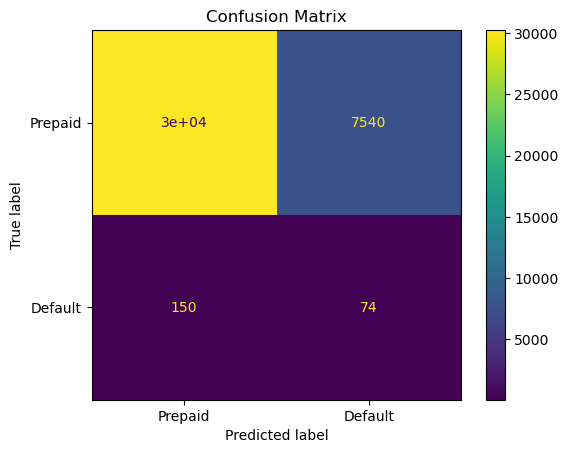

In [37]:
# Use the same y_pred everywhere
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Prepaid", "Default"])
plt.figure(figsize=(3, 2)) ; disp.plot(); plt.title(f"Confusion Matrix"); plt.show()

**Interpretation**: Despite using GridSearch to optimise recall and class weights & SMOTE to balance the data, the model's recall for predicting defaults remains low at 0.33. While the model performs very well in identifying prepaid loans with a high recall of 0.89 and precision of 1.00, it fails to correctly identify a significant portion of default loans. This confusion matrix shows that 30,000 prepaid loans were correctly classified, while 7,540 prepaid loans were incorrectly predicted as defaults (false positives). On the other hand, the model correctly identified 74 defaults, but misclassified 150 defaults as prepaid loans (false negatives). As a result, the recall for defaults is considerably lower compared to logistic regression, indicating that the Random Forest model struggles to capture the minority class despite the efforts to improve its performance.

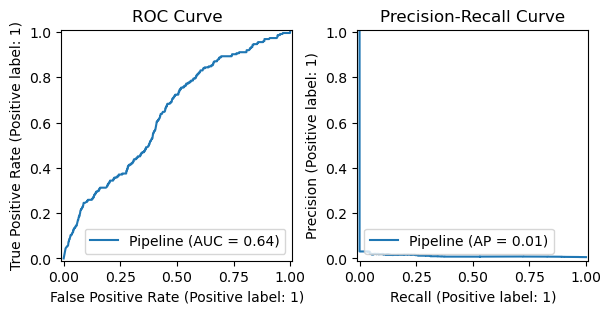

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
# ROC curve plot
RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test, ax=axes[0])
axes[0].set_title('ROC Curve')
# Precision-Recall curve plot
PrecisionRecallDisplay.from_estimator(rf_pipe, X_test, y_test, ax=axes[1])
axes[1].set_title('Precision-Recall Curve')
plt.show()

Both the Random Forest and Logistic Regression models exhibit similar behavior in the Precision-Recall Display, with the curves showing almost the same pattern, indicating similar performance in terms of precision and recall. However, the Random Forest model has a lower AUC score of 0.66 compared to the Logistic Regression model, which achieved an AUC of 0.74. This suggests that Logistic Regression provides better overall discrimination between classes, as the AUC is a comprehensive measure of a model's ability to distinguish between the positive and negative classes. 

### 6. Feature Importance

The plot below illustrates how one of the 250 trees in our Random Forest model makes classification decisions. Each internal node represents a decision rule based on a specific feature, splitting the dataset into smaller subsets. The tree uses features such as zip code, servicer name, and property type to determine whether a loan is more likely to be prepaid or defaulted. Despite the overall complexity of the full ensemble, each individual tree is relatively simple

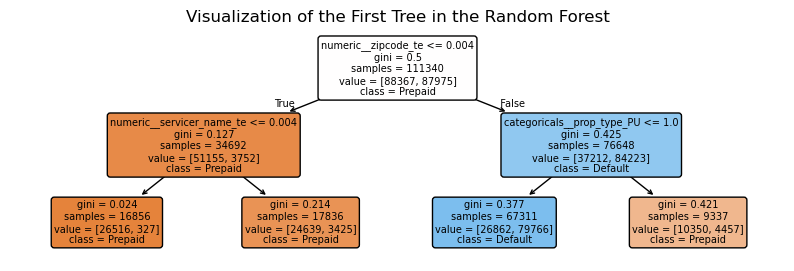

In [51]:
# Extract the trained RandomForest model from the pipeline
rf_model = rf_pipe.named_steps['model']
# Get the first tree from the forest
first_tree = rf_model.estimators_[0]
# Get feature names after preprocessing
feature_names = rf_pipe.named_steps['preprocessor'].get_feature_names_out()
# Plot the first decision tree
plt.figure(figsize=(10, 3))
plot_tree(first_tree, 
          feature_names=feature_names, 
          class_names=['Prepaid', 'Default'],
          filled=True, rounded=True)
plt.title("Visualization of the First Tree in the Random Forest")
plt.show()

In a Random Forest model, unlike in logistic regression, there are no explicit coefficients that represent the relationship between each feature and the target variable. Instead, Random Forests rely on feature importance scores, which indicate the relative importance of each feature in making predictions. These importance scores are derived from how frequently and effectively a feature is used in the decision trees within the forest. Higher feature importance means the feature is more influential in predicting the target variable.

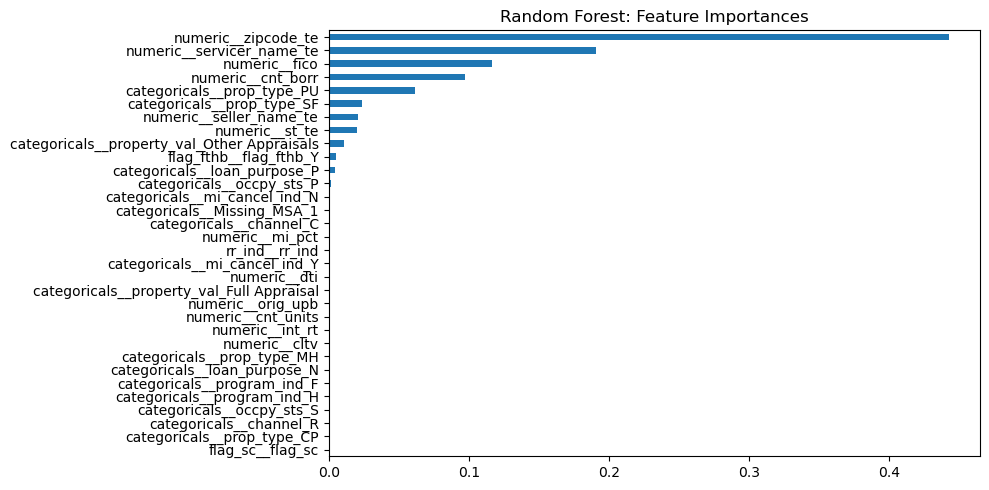

In [48]:
plt.figure(figsize=(10, 5)) 
# Extract feature names after preprocessing
feature_names = rf_pipe.named_steps['preprocessor'].get_feature_names_out()
# Create a pandas series with the feature importances
importances = pd.Series(
    rf_pipe.named_steps['model'].feature_importances_, index=feature_names
).sort_values(ascending=True)
# Plot the feature importances
ax = importances.plot.barh()
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()
plt.show() 

This feature importance plot from the Random Forest model reveals that only a small subset of variables significantly influenced the model’s predictions. In particular, zip code, servicer name, number of borrowers, and credit score stand out as the most important predictors of mortgage default. These features collectively account for the vast majority of the model’s decision-making power. All other features contribute very little and are close to zero in importance. This outcome suggests that the Random Forest model heavily relies on a few key indicators while ignoring most others, which may be due to feature dominance, redundancy, or interactions captured early in tree splits.

### 7. Model Comparison

1. Class Imbalance Handling

- Logistic Regression (Logistic): Handles class imbalance well with class weights, making it effective at identifying the minority class (defaults) without complex preprocessing.

- Random Forest (RF): Requires additional steps like SMOTE to generate more instances of the minority class. Without this, RF would predict the majority class overwhelmingly, failing to capture defaults. SMOTE improved default recognition but added complexity.

2. Model Performance and AUC

- Logistic Regression: Outperforms RF with a higher AUC of 0.74, making it better for accurate classification and ranking predictions.

- Random Forest: Has a lower AUC of 0.66, indicating weaker class distinction but compensates by capturing more defaults, which is crucial for this application.

3. Model Recall

- Logistic Regression: Demonstrates higher recall, effectively identifying more defaults, making it suitable for default detection.

- Random Forest: Despite optimizations, RF's recall is still lower than Logistic Regression, reflecting its limitations in capturing the minority class.

4. Interpretability and Complexity

- Logistic Regression: Offers clear, interpretable coefficients, making it easy to understand how features affect default risk.

- Random Forest: Provides feature importance values but lacks clarity on whether a feature increases or decreases default risk, making it harder to interpret and more complex.

#### ❗️❗️❗️ Final model choice is to stick with Logistic Regression❗️❗️❗️

After considering the results from both Logistic Regression and Random Forest models, we have decided to use Logistic Regression for identifying at-risk loans in the active loan dataset. Although Random Forest showed potential for capturing more defaults with the help of SMOTE, its lower recall and higher complexity made Logistic Regression a more reliable and interpretable choice. Logistic Regression offers clear coefficients, higher recall, and simplicity, making it better suited for flagging problematic loans while ensuring transparency and ease of understanding.

### 8. Applying the Final Model to Active Loans for Default Prediction

In this section, we apply the final logistic regression model to predict the risk of default in a set of active loans. By leveraging the default prediction probabilities derived from the model, we can identify loans that are at a higher risk of default. These high-risk loans, flagged by the model, are crucial for further investigation and targeted risk management. 

In [83]:
X_active = df_active.drop(columns=["loan_status"])
for col in ['seller_name', 'servicer_name', 'st', "zipcode"]:
    means = X_train_enc.groupby(col)['target'].mean() # default rate per category
    global_mean = y_train.mean()
    # Map means to training data
    df_active[col + '_te'] = df_active[col].map(means).fillna(global_mean)
# Now apply the model pipeline to df_active
# transform features with the pipeline 
X_active = df_active.drop(columns=["loan_status"])
X_active_transformed = log_preprocessor.fit_transform(X_active)
# Get probabilities for the positive class (default)
y_proba_active = log_pipe.named_steps['logisticregression'].predict_proba(X_active_transformed)[:, 1]

In [84]:
# Add the predicted probabilities back to the DataFrame
df_active['default_probability'] = y_proba_active
# Filter the active loans with default probability greater than the threshold
df_active_high_risk = df_active[df_active['default_probability'] > 0.5]

In [85]:
proportion_high_risk = (df_active['default_probability'] > 0.5).mean()
length_high_risk = (df_active['default_probability'] > 0.5).sum()
print(f"Proportion of high-risk loans (probability > 0.5): {proportion_high_risk:.2f}; total of {length_high_risk} out of 73,295	")

Proportion of high-risk loans (probability > 0.5): 0.21; total of 15744 out of 73,295	


Based on the default rate observed in the total loan population, approximately 430 defaults can be expected among the 73,295 active loans. Given that the model flags 15,744 high-risk loans (21% of the total), we can expect to capture around half of the defaults with a recall of about 45%. If the bank aims to narrow its focus to fewer, more concerning cases, raising the probability threshold above 0.5 would reduce the number of flagged loans. This would allow for more targeted interventions, prioritizing only the most at-risk borrowers.

# Discussion & Conclusions


#### Model Performance and Interpretability:

After evaluating different approaches, we selected Logistic Regression as the final model for predicting default risk. Although Random Forest showed promise, it was not chosen due to lower recall despite optimizations like grid search, SMOTE, and class weights. RF's complexity and lack of interpretability further reinforced our decision to favor Logistic Regression, which provided more reliable and interpretable results.

#### Understanding Default Risk:
The logistic regression model identifies several key risk factors for mortgage defaults. One significant variable is the type of property appraisal method used. Loans with non-standard appraisals, like desktop or drive-by methods, tend to have a higher default risk compared to loans with traditional ACE Loan appraisals. This suggests that alternative appraisals may overvalue properties, increasing the chance of default if property values decline.

Another critical factor is mortgage insurance (MI) status. Loans where MI is either not canceled or has been canceled show a higher risk of default, reflecting potential financial instability. Mortgage insurance serves as a safety net, and its absence may indicate financial stability of borrowers.

The debt-to-income (DTI) ratio is also a strong predictor of default. Higher DTI ratios mean borrowers are committing more of their income to debt repayment, making them more vulnerable to financial strain and increasing default likelihood.

Geographic location, particularly zip codes, plays a crucial role in predicting defaults, with certain areas having historically higher default rates due to local economic conditions or housing market dynamics. Location appears to be a stronger predictor than state-level data.

Additionally, property types such as manufactured homes are more likely to default, possibly due to lower property values and higher maintenance costs. This poses a greater risk for lenders compared to other property types, like condominiums.

Refinanced loans, primary and secondary residences, and loans with streamlined credit flags show lower default risks, reflecting more favorable financial conditions or loan terms. Lastly, higher FICO scores correlate with a reduced risk of default, as individuals with better credit histories are more financially stable.

However, Random Forest (RF) modeling highlighted that **a simple model using only zip code, property type, servicer name, FICO score, and the number of borrowers** could effectively predict defaults, simplifying the approach without compromising performance.

#### Model Limitations and Future Improvements:

While Logistic Regression offers high recall, it struggles to capture complex feature interactions. Although Random Forest models can handle such complexity, they failed to achieve the desired recall despite grid search and SMOTE optimization. Future tuning, especially around feature selection, is necessary to optimize Random Forest.

***A key and crucial limitation is the use of zip codes***, which may introduce bias tied to socio-economic status, class and race. Even if zip codes are removed, indirect biases may remain through other features, such as servicer and seller names, which often reflect regional patterns. Future work should focus on careful feature selection to mitigate these risks, ensuring the model doesn't unintentionally discriminate and performs effectively while minimizing biases.

#### Recommendations:

- Continue tuning Random Forest (RF): Further optimization of hyperparameters in RF and more careful feature selection can potentially improve model performance, as RF's complexity and feature interaction capabilities were not fully realized in this study.

- Consider vulnerability of geographic, seller, and servicer data: Be cautious when including sensitive variables such as zip codes, seller, and servicer names, as these can unintentionally encode socio-economic or demographic information, leading to potential discrimination or biased outcomes.

- Add time series component: Including time series data, which was skipped in this analysis, could provide more dynamic insights into default risks over time, particularly for loans with changing conditions or trends.

- Add target encoding to pipeline: Incorporating target encoding for high-cardinality categorical features (such as seller and servicer names) directly into the pipeline could streamline the process and potentially reduce the complexity of the model.

- Focus on key predictors of default: Major risk factors identified include property appraisal methods, mortgage insurance status, debt-to-income ratios, and geographic location. Additionally, loans with higher credit scores, primary residences, and refinanced loans are less likely to default.

#### Conclusion:

In conclusion, the logistic regression model has proven to be a reliable and interpretable tool for predicting mortgage defaults. By focusing on key risk factors we have been able to identify significant predictors of default. While Random Forest showed promise in its ability to capture complex relationships, it ultimately underperformed in terms of recall, largely due to the challenges of class imbalance and the complexity of its parameters. Our decision to use logistic regression stems from its clarity, ease of interpretation, and strong performance despite the limitations of capturing intricate feature interactions.

Moving forward, further tuning of Random Forest and careful feature selection could enhance its performance, but ***attention must be paid to the ethical concerns surrounding the use of sensitive features like geographic and institutional data***. Moreover, incorporating time series data and target encoding into the pipeline could improve the model's predictive power. Ultimately, the insights derived from this model can help lending institutions make more informed decisions, mitigate risks, and develop strategies to manage and reduce the likelihood of mortgage defaults.

# Generative AI statement

Generative AI was used for debugging and grammar checking. Used also for plotting. 